<a href="https://colab.research.google.com/github/subarnasth/captcha/blob/master/Captcha_Solver_Alphanumerical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
%pip install captcha 
%pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
%pip install keras


import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

import os
import cv2
import numpy as np
from random import random, randint, choices

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
71 packages can be upgraded. Run 'ap

In [22]:
alphabet_all = list('qwertyupasdfghjkzxcvbnm23456789QWERTYUPKJHGFDSAZXCVBNM')
alphabet = list('qwertyupasdfghjkzxcvbnm23456789')#QWERTYUIOPLKJHGFDSAZXCVBNM')
num_alphabet = len(alphabet)
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [23]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135

# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

In [24]:
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                for i in range(NUM_OF_LETTERS):
                    label[i, alphabet.index(flr[i].lower())] = 1
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [25]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 700*1000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

Generating Dataset
Finished Data Generation


In [26]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 700000 (train=630345, test=69655)


In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(630345, 25, 67, 1)
(630345, 5, 31)
(69655, 25, 67, 1)
(69655, 5, 31)


In [28]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [29]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [30]:
input_layer = Input((25, 67, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
# out = Dense(num_alphabet*5, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=out)

In [31]:
# model_path = os.path.join(save_dir, model_name)
# model = keras.models.load_model(model_path)

In [32]:
# initiate Adam optimizer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 67, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 33, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 33, 48)   38448       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [33]:
hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [34]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [38]:

history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Epoch 1/50
4925/4925 [==============================] - 72s 15ms/step - loss: 0.0583 - digit0_loss: 0.0078 - digit1_loss: 0.0139 - digit2_loss: 0.0151 - digit3_loss: 0.0138 - digit4_loss: 0.0077 - digit0_accuracy: 0.9584 - digit1_accuracy: 0.9250 - digit2_accuracy: 0.9189 - digit3_accuracy: 0.9253 - digit4_accuracy: 0.9586 - val_loss: 0.0295 - val_digit0_loss: 0.0035 - val_digit1_loss: 0.0072 - val_digit2_loss: 0.0078 - val_digit3_loss: 0.0071 - val_digit4_loss: 0.0038 - val_digit0_accuracy: 0.9808 - val_digit1_accuracy: 0.9611 - val_digit2_accuracy: 0.9586 - val_digit3_accuracy: 0.9620 - val_digit4_accuracy: 0.9797
Epoch 2/50
4925/4925 [==============================] - 75s 15ms/step - loss: 0.0582 - digit0_loss: 0.0078 - digit1_loss: 0.0140 - digit2_loss: 0.0151 - digit3_loss: 0.0138 - digit4_loss: 0.0076 - digit0_accuracy: 0.9581 - digit1_accuracy: 0.9243 - digit2_accuracy: 0.9191 - digit3_accuracy: 0.9258 - digit4_accuracy: 0.9592 - val_loss: 0.0287 - val_digit0_loss: 0.0034 - val_

In [44]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()



    # Plot training & validation loss values
    
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

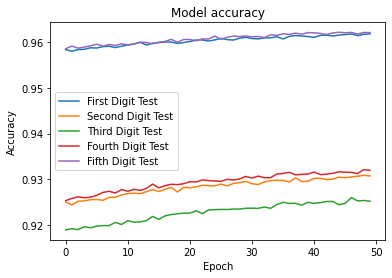

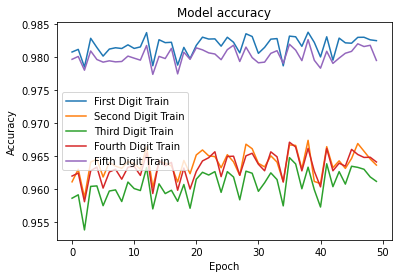

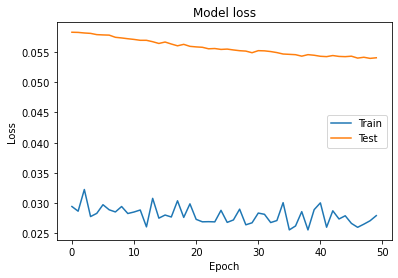

In [45]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [41]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


In [42]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))

19699/19699 [==============================] - 100s 5ms/step - loss: 0.0232 - digit0_loss: 0.0028 - digit1_loss: 0.0057 - digit2_loss: 0.0061 - digit3_loss: 0.0056 - digit4_loss: 0.0030 - digit0_accuracy: 0.9846 - digit1_accuracy: 0.9701 - digit2_accuracy: 0.9692 - digit3_accuracy: 0.9710 - digit4_accuracy: 0.9838
Train loss:     0.008698
Train accuracy: 88.42


In [43]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

2177/2177 [==============================] - 11s 5ms/step - loss: 0.0279 - digit0_loss: 0.0032 - digit1_loss: 0.0068 - digit2_loss: 0.0074 - digit3_loss: 0.0068 - digit4_loss: 0.0038 - digit0_accuracy: 0.9825 - digit1_accuracy: 0.9637 - digit2_accuracy: 0.9612 - digit3_accuracy: 0.9641 - digit4_accuracy: 0.9795
Test loss:     0.010425
Test accuracy: 85.95
